In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
from bs4 import BeautifulSoup
from unidecode import unidecode
import torch
from sklearn.metrics.pairwise import cosine_similarity
from googletrans import Translator

import warnings
warnings.filterwarnings('ignore')

In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Tienn
[nltk_data]     Vo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
# Load tokenizer và model PhoBERT
# tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
# phobert = AutoModel.from_pretrained("vinai/phobert-base")

In [22]:
# Tạo đối tượng Translator
translator = Translator()

def translate_text(text):
    try:
        if pd.notnull(text):  # Chỉ dịch nếu văn bản không rỗng
            return translator.translate(text, src='en', dest='vi').text
    except Exception as e:
        return translate_text(str(e))  # Nếu lỗi, giữ nguyên văn bản gốc
    return text

In [3]:
# from libretranslate import LibreTranslateAPI
import requests
def translate_text(text, src='en', dest='vi'):
    url = "https://libretranslate.com/translate"
    payload = {
        "q": text,
        "source": src,
        "target": dest,
        "format": "text"
    }
    headers = {"Content-Type": "application/json"}

    try:
        response = requests.post(url, json=payload, headers=headers)
        if response.status_code == 200:
            return response.json()["translatedText"]
        else:
            print(f"Lỗi khi dịch: {response.status_code} - {response.text}")
            return text
    except Exception as e:
        print(f"Lỗi kết nối: {e}")
        return text

# Ví dụ sử dụng
text = "Hello, how are you?"
translated_text = translate_text(text, src='en', dest='vi')
print(translated_text)  # Output: "Xin chào, bạn có khỏe không?"

Lỗi khi dịch: 400 - {"error":"Visit https://portal.libretranslate.com to get an API key"}

Hello, how are you?


In [21]:
file_path = 'vietnamese-stopwords.txt'
with open(file_path, 'r', encoding='utf-8') as file:
    STOP_WORDS = set(file.read().splitlines())

print(STOP_WORDS)

{'với', 'gần đến', 'đặt để', 'nhung nhăng', 'phải lại', 'tuy nhiên', 'sang sáng', 'ứ ừ', 'ít nữa', 'đến xem', 'quá nhiều', 'úi chà', 'chính giữa', 'ngay lúc', 'chết tiệt', 'bấy lâu nay', 'ngày xưa', 'qua lại', 'vừa qua', 'lấy ráo', 'phỏng nước', 'buổi', 'khẳng định', 'dạ con', 'thêm chuyện', 'thoạt nhiên', 'chứ như', 'đến tuổi', 'rồi tay', 'oái', 'thường tính', 'ít', 'trước', 'anh', 'như ý', 'hiện nay', 'đâu', 'hoặc', 'ngay cả', 'răng răng', 'tính từ', 'ngày tháng', 'phần nhiều', 'tình trạng', 'chịu chưa', 'hết ý', 'nhìn nhận', 'trực tiếp làm', 'lại nói', 'tốt ngày', 'cho tới', 'đặt mình', 'a lô', 'sau cuối', 'có ý', 'ví dù', 'đưa ra', 'làm ngay', 'nghe nhìn', 'nhất định', 'trước khi', 'nhà ngươi', 'ít ra', 'nói đến', 'bập bà bập bõm', 'cái đã', 'thật quả', 'tắp tắp', 'tới thì', 'thà là', 'bấy chừ', 'tìm cách', 'sì', 'tốt mối', 'ngày rày', 'nói ý', 'không cùng', 'chị', 'vốn dĩ', 'thường khi', 'mọi người', 'hết của', 'tự vì', 'xăm xúi', 'ở', 'ổng', 'tin', 'cứ', 'lúc nào', 'nó', 'bệt', '

In [15]:
df = pd.read_csv('D:/Python/Quora/Quora/quora-question-pairs/Data/Dataset/train/train.csv')

In [16]:
df.head()

id  qid1  qid2                                          question1  \
0   0     1     2                                    tiennvo la ai ?   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0                                    ai la tiennvo ?             1  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31202 entries, 0 to 31201
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            31202 non-null  int64 
 1   qid1          31202 non-null  int64 
 2   qid2          31202 non-null  int64 
 3   question1     31202 non-null  object
 4   question2     31202 non-null  object
 5   is_duplicate  31202 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 1.4+ MB


In [20]:
# new_df = df.sample(12000,random_state=2)
new_df = df.head()

In [21]:
new_df

id  qid1  qid2                                          question1  \
0   0     1     2                                    tiennvo la ai ?   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0                                    ai la tiennvo ?             1  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0

In [24]:
# Dịch hai cột `question1` và `question2`
new_df['question1_translated'] = new_df['question1'].apply(translate_text)
new_df['question2_translated'] = new_df['question2'].apply(translate_text)

new_df['question1'] = new_df['question1_translated']
new_df['question2'] = new_df['question2_translated']


In [26]:
new_df = new_df.drop(columns=['question1_translated', 'question2_translated'])
data = new_df.applymap(lambda x: f'"{x}"')
output_file = 'tiennvodata.csv'
data.to_csv(output_file, index=False, encoding='utf-8-sig')

In [30]:
def preprocess(q):
    
    q = str(q).lower().strip()
    
    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    contractions = { 
    "sn": "sinh năm",
    "bn": "bao nhiêu",
    "ngta": "người ta",
    "lm": "làm",
    "khg": "không",
    "ko": "không",
    "hok": "không",
    "khum": "không",
    "kg": "không",
    "đc": "được",
    "dc": "được",
    "đg": "đang",
    "ng": "người",
    "bt": "biết",
    "h": "giờ",
    "hc": "học",
    "vt": "viết",
    "vc": "việc",
    "trc": "trước",
    "j": "gì",
    "xg": "xong",
    "bx": "bữa",
    "vg": "vâng",
    "v": "vậy",
    "m": "mày",
    "t": "tôi",
    "s": "sao",
    "r": "rồi",
    "chs": "chơi",
    "ae": "anh em",
    "a": "anh",
    "e": "em",
    "cj": "chị",
    "đhsp": "đại học sư phạm",
    "đh": "đại học",
    "đhspkt": "đại học sư phạm kỹ thuật",
    "ktx": "kí túc xá",
    "đt": "điện thoại",
    "cntt": "công nghệ thông tin",
    "tp": "thành phố",
    "hcm": "hồ chí minh",
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    # q = q.replace("dc", "được")
    # q = q.replace("cx", "cũng")
    # q = q.replace("j", "gì")
    
    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()
    #q = unidecode(q)
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()

    
    return q
    

In [31]:
preprocess("tiến võ<b>done</b>?")

'tiến võdone'

In [32]:
new_df['question1'] = new_df['question1'].apply(preprocess)
new_df['question2'] = new_df['question2'].apply(preprocess)

In [33]:
new_df.head()

id  qid1  qid2                                          question1  \
0   0     1     2            tháng 8 còn trường nào xét học bạ không   
1   1     3     4  chính sách hỗ trợ học phí cho sinh viên sư phạ...   
2   2     5     6  trường đại học sư phạm có cho thiếu học bạ tro...   
3   3     7     8  chương trình học ngành sp nga có phải 100 perc...   
4   4     9    10  không thuộc đối tượng ưu tiên có thể đăng kí ở...   

                                           question2  is_duplicate  
0  những trường đại học còn nhận học bạ trong thá...             1  
1  những điều cần biết về chính sách hỗ trợ học p...             1  
2  có thể bổ sung học bạ sau khi nộp hồ sơ vào đạ...             1  
3  xuyên suốt bài giảng ngành sp nga có phải 100 ...             1  
4           điều kiện đăng ký ở ký túc xá của trường             1

In [34]:
new_df['q1_len'] = new_df['question1'].str.len() 
new_df['q2_len'] = new_df['question2'].str.len()

In [35]:
new_df.head()

id  qid1  qid2                                          question1  \
0   0     1     2            tháng 8 còn trường nào xét học bạ không   
1   1     3     4  chính sách hỗ trợ học phí cho sinh viên sư phạ...   
2   2     5     6  trường đại học sư phạm có cho thiếu học bạ tro...   
3   3     7     8  chương trình học ngành sp nga có phải 100 perc...   
4   4     9    10  không thuộc đối tượng ưu tiên có thể đăng kí ở...   

                                           question2  is_duplicate  q1_len  \
0  những trường đại học còn nhận học bạ trong thá...             1      39   
1  những điều cần biết về chính sách hỗ trợ học p...             1      59   
2  có thể bổ sung học bạ sau khi nộp hồ sơ vào đạ...             1      69   
3  xuyên suốt bài giảng ngành sp nga có phải 100 ...             1      65   
4           điều kiện đăng ký ở ký túc xá của trường             1      67   

   q2_len  
0      50  
1      70  
2      65  
3      68  
4      40

In [36]:
new_df['q1_num_words'] = new_df['question1'].apply(lambda row: len(row.split(" ")))
new_df['q2_num_words'] = new_df['question2'].apply(lambda row: len(row.split(" ")))
new_df.head()

id  qid1  qid2                                          question1  \
0   0     1     2            tháng 8 còn trường nào xét học bạ không   
1   1     3     4  chính sách hỗ trợ học phí cho sinh viên sư phạ...   
2   2     5     6  trường đại học sư phạm có cho thiếu học bạ tro...   
3   3     7     8  chương trình học ngành sp nga có phải 100 perc...   
4   4     9    10  không thuộc đối tượng ưu tiên có thể đăng kí ở...   

                                           question2  is_duplicate  q1_len  \
0  những trường đại học còn nhận học bạ trong thá...             1      39   
1  những điều cần biết về chính sách hỗ trợ học p...             1      59   
2  có thể bổ sung học bạ sau khi nộp hồ sơ vào đạ...             1      69   
3  xuyên suốt bài giảng ngành sp nga có phải 100 ...             1      65   
4           điều kiện đăng ký ở ký túc xá của trường             1      67   

   q2_len  q1_num_words  q2_num_words  
0      50             9            11  
1      70            14            16  
2      65            16            17  
3      68            13            14  
4      40            16            10

In [37]:
def get_bert_embedding(sentence, tokenizer, model):
    # Tokenize câu hỏi
    inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)
    
    # Dùng mô hình để tính toán embedding
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Lấy vector [CLS] làm đại diện cho toàn bộ câu
    embedding = outputs.last_hidden_state[:, 0, :].squeeze(0).numpy()  # Vector [CLS]
    return embedding

In [38]:
def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return len(w1 & w2)

In [39]:
new_df['word_common'] = new_df.apply(common_words, axis=1)
new_df.head()

id  qid1  qid2                                          question1  \
0   0     1     2            tháng 8 còn trường nào xét học bạ không   
1   1     3     4  chính sách hỗ trợ học phí cho sinh viên sư phạ...   
2   2     5     6  trường đại học sư phạm có cho thiếu học bạ tro...   
3   3     7     8  chương trình học ngành sp nga có phải 100 perc...   
4   4     9    10  không thuộc đối tượng ưu tiên có thể đăng kí ở...   

                                           question2  is_duplicate  q1_len  \
0  những trường đại học còn nhận học bạ trong thá...             1      39   
1  những điều cần biết về chính sách hỗ trợ học p...             1      59   
2  có thể bổ sung học bạ sau khi nộp hồ sơ vào đạ...             1      69   
3  xuyên suốt bài giảng ngành sp nga có phải 100 ...             1      65   
4           điều kiện đăng ký ở ký túc xá của trường             1      67   

   q2_len  q1_num_words  q2_num_words  word_common  
0      50             9            11            6  
1      70            14            16           11  
2      65            16            17            9  
3      68            13            14            8  
4      40            16            10            5

In [40]:
def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return (len(w1) + len(w2))

In [41]:
new_df['word_total'] = new_df.apply(total_words, axis=1)
new_df.head()

id  qid1  qid2                                          question1  \
0   0     1     2            tháng 8 còn trường nào xét học bạ không   
1   1     3     4  chính sách hỗ trợ học phí cho sinh viên sư phạ...   
2   2     5     6  trường đại học sư phạm có cho thiếu học bạ tro...   
3   3     7     8  chương trình học ngành sp nga có phải 100 perc...   
4   4     9    10  không thuộc đối tượng ưu tiên có thể đăng kí ở...   

                                           question2  is_duplicate  q1_len  \
0  những trường đại học còn nhận học bạ trong thá...             1      39   
1  những điều cần biết về chính sách hỗ trợ học p...             1      59   
2  có thể bổ sung học bạ sau khi nộp hồ sơ vào đạ...             1      69   
3  xuyên suốt bài giảng ngành sp nga có phải 100 ...             1      65   
4           điều kiện đăng ký ở ký túc xá của trường             1      67   

   q2_len  q1_num_words  q2_num_words  word_common  word_total  
0      50             9            11            6          19  
1      70            14            16           11          30  
2      65            16            17            9          30  
3      68            13            14            8          25  
4      40            16            10            5          24

In [42]:
new_df['word_share'] = round(new_df['word_common']/new_df['word_total'],2)
new_df.head()

id  qid1  qid2                                          question1  \
0   0     1     2            tháng 8 còn trường nào xét học bạ không   
1   1     3     4  chính sách hỗ trợ học phí cho sinh viên sư phạ...   
2   2     5     6  trường đại học sư phạm có cho thiếu học bạ tro...   
3   3     7     8  chương trình học ngành sp nga có phải 100 perc...   
4   4     9    10  không thuộc đối tượng ưu tiên có thể đăng kí ở...   

                                           question2  is_duplicate  q1_len  \
0  những trường đại học còn nhận học bạ trong thá...             1      39   
1  những điều cần biết về chính sách hỗ trợ học p...             1      59   
2  có thể bổ sung học bạ sau khi nộp hồ sơ vào đạ...             1      69   
3  xuyên suốt bài giảng ngành sp nga có phải 100 ...             1      65   
4           điều kiện đăng ký ở ký túc xá của trường             1      67   

   q2_len  q1_num_words  q2_num_words  word_common  word_total  word_share  
0      50             9            11            6          19        0.32  
1      70            14            16           11          30        0.37  
2      65            16            17            9          30        0.30  
3      68            13            14            8          25        0.32  
4      40            16            10            5          24        0.21

In [43]:
# from sklearn.metrics.pairwise import cosine_similarity

# def compute_phobert_embedding(sentence):
#     """
#     Trích xuất embedding của câu bằng PhoBERT.
#     """
#     inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True, max_length=256)
#     outputs = phobert(**inputs)
#     # Sử dụng giá trị trung bình của embedding lớp cuối cùng
#     embedding = torch.mean(outputs.last_hidden_state, dim=1).detach().numpy()
#     return embedding

# def test_phobert_features(q1, q2):
#     """
#     Tính toán độ tương đồng ngữ nghĩa giữa hai câu hỏi sử dụng PhoBERT.
#     """
#     q1_embedding = compute_phobert_embedding(q1)
#     q2_embedding = compute_phobert_embedding(q2)
#     similarity = cosine_similarity(q1_embedding, q2_embedding)[0][0]
#     return similarity

# new_df['phobert_similarity'] = new_df.apply(lambda row: test_phobert_features(row['question1'], row['question2']), axis=1)
# print(new_df.shape)


In [44]:
new_df.sample(10)

id    qid1    qid2  \
17465  105429  173856  173857   
15512   10620   20554   20555   
12111  281893  401733  401734   
19790  358413  487893  487894   
19561  130598  209556   54732   
22738  240752    5160  352638   
15092  284741  405053  405054   
10845   91035  152645  152646   
21056  104635  172729    3664   
10560  246692   55681  245244   

                                               question1  \
17465  các công cụ soạn thảo và công dụng của chúng l...   
15512  có thể loại bỏ hệ thống đặt phòng dựa trên đẳn...   
12111  skydiving  có bao nhiêu người chết mỗi năm do ...   
19790         máy ảnh kỹ thuật số được phát minh khi nào   
19561  kinh doanh tốt nhất để bắt đầu ở các thành phố...   
22738  tôi đã nói với một cô gái trong một mối quan h...   
15092  bạn có thể làm gì miễn phí mà bạn có thể bán v...   
10845  làm thế nào bạn có thể xác định cấu trúc lewis...   
21056  tôi có thể làm gì với cuộc sống của mình  và k...   
10560  làm thế nào an toàn cho các cô gái đi du lịch ...   

                                               question2  is_duplicate  \
17465  là một bàn soạn thảo có thể được sử dụng như m...             0   
15512  làm thế nào có thể thay đổi hệ thống đặt phòng...             1   
12111  có bao nhiêu khoảng trống được thực hiện mỗi n...             0   
19790         tại sao máy ảnh kỹ thuật số được phát minh             0   
19561  công việc kinh doanh tốt nhất để bắt đầu ở một...             1   
22738  tôi đã nói với một cô gái có bạn trai mà tôi t...             1   
15092  làm thế nào tôi có thể kiếm được 100 đô la một...             0   
10845  làm thế nào bạn có thể xác định cấu trúc lewis...             0   
21056  làm thế nào để bạn tìm thấy mục đích của cuộc ...             0   
10560       có an toàn cho một cô gái đi du lịch ở ấn độ             1   

       q1_len  q2_len  q1_num_words  q2_num_words  word_common  word_total  \
17465      50      67            12            16            4          25   
15512      83      64            21            15           10          34   
12111      59      57            14            13            5          27   
19790      42      42            10            10            8          20   
19561      56      81            14            19           13          33   
22738     175     165            45            43           30          63   
15092      62      63            17            15            6          29   
10845      55      56            13            13           12          26   
21056      63      58            17            14            4          25   
10560      62      44            17            13           12          30   

       word_share  
17465        0.16  
15512        0.29  
12111        0.19  
19790        0.40  
19561        0.39  
22738        0.48  
15092        0.21  
10845        0.46  
21056        0.16  
10560        0.40

In [45]:
# Advanced Features
from nltk.corpus import stopwords

def fetch_token_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    SAFE_DIV = 0.0001 

    # STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features


In [46]:
token_features = new_df.apply(fetch_token_features, axis=1)

new_df["cwc_min"]       = list(map(lambda x: x[0], token_features)) #Tỷ lệ từ không phải stopwords chung so với số lượng từ tối thiểu.
new_df["cwc_max"]       = list(map(lambda x: x[1], token_features)) #Tỷ lệ từ không phải stopwords chung so với số lượng từ tối đa.
new_df["csc_min"]       = list(map(lambda x: x[2], token_features)) #Tỷ lệ stopwords chung so với số lượng stopwords tối thiểu.
new_df["csc_max"]       = list(map(lambda x: x[3], token_features)) #Tỷ lệ stopwords chung so với số lượng stopwords tối đa.
new_df["ctc_min"]       = list(map(lambda x: x[4], token_features)) #Tỷ lệ tokens chung so với số lượng tokens tối thiểu.
new_df["ctc_max"]       = list(map(lambda x: x[5], token_features)) #Tỷ lệ tokens chung so với số lượng tokens tối đa.
new_df["last_word_eq"]  = list(map(lambda x: x[6], token_features)) #Kiểm tra từ cuối cùng của hai câu hỏi có giống nhau không (1 nếu giống, 0 nếu khác).
new_df["first_word_eq"] = list(map(lambda x: x[7], token_features)) #Kiểm tra từ đầu tiên của hai câu hỏi có giống nhau không (1 nếu giống, 0 nếu khác).

In [47]:
new_df.head()

id  qid1  qid2                                          question1  \
0   0     1     2            tháng 8 còn trường nào xét học bạ không   
1   1     3     4  chính sách hỗ trợ học phí cho sinh viên sư phạ...   
2   2     5     6  trường đại học sư phạm có cho thiếu học bạ tro...   
3   3     7     8  chương trình học ngành sp nga có phải 100 perc...   
4   4     9    10  không thuộc đối tượng ưu tiên có thể đăng kí ở...   

                                           question2  is_duplicate  q1_len  \
0  những trường đại học còn nhận học bạ trong thá...             1      39   
1  những điều cần biết về chính sách hỗ trợ học p...             1      59   
2  có thể bổ sung học bạ sau khi nộp hồ sơ vào đạ...             1      69   
3  xuyên suốt bài giảng ngành sp nga có phải 100 ...             1      65   
4           điều kiện đăng ký ở ký túc xá của trường             1      67   

   q2_len  q1_num_words  q2_num_words  ...  word_total  word_share   cwc_min  \
0      50             9            11  ...          19        0.32  0.799984   
1      70            14            16  ...          30        0.37  0.999989   
2      65            16            17  ...          30        0.30  0.777769   
3      68            13            14  ...          25        0.32  0.666659   
4      40            16            10  ...          24        0.21  0.666656   

    cwc_max   csc_min   csc_max   ctc_min   ctc_max  last_word_eq  \
0  0.799984  0.499988  0.399992  0.666659  0.545450           0.0   
1  0.999989  0.399992  0.285710  0.785709  0.687496           0.0   
2  0.636358  0.399992  0.399992  0.562496  0.529409           1.0   
3  0.666659  0.666644  0.499988  0.615380  0.571424           0.0   
4  0.399996  0.333322  0.199996  0.499995  0.312498           0.0   

   first_word_eq  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0  

[5 rows x 21 columns]

In [48]:
import distance

def fetch_length_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    length_features = [0.0]*3
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # sự khác biệt về số lượng tokens
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    # độ dài trung bình của các tokens
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2
    
    strs = list(distance.lcsubstrings(q1, q2))

    if strs:  # Chuỗi con chung dài nhất / Độ dài tối thiểu của hai câu hỏi
        length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)
    else:
        length_features[2] = 0.0  # Giá trị mặc định nếu không có chuỗi con chung
    
    return length_features
    

In [49]:
length_features = new_df.apply(fetch_length_features, axis=1)

new_df['abs_len_diff'] = list(map(lambda x: x[0], length_features)) # Sự khác biệt tuyệt đối về số lượng tokens giữa hai câu hỏi.
new_df['mean_len'] = list(map(lambda x: x[1], length_features)) # Độ dài trung bình của các tokens trong hai câu hỏi.
new_df['longest_substr_ratio'] = list(map(lambda x: x[2], length_features)) # Tỷ lệ độ dài của chuỗi con chung dài nhất so với độ dài tối thiểu của hai câu hỏi.

In [50]:
new_df.head()

id  qid1  qid2                                          question1  \
0   0     1     2            tháng 8 còn trường nào xét học bạ không   
1   1     3     4  chính sách hỗ trợ học phí cho sinh viên sư phạ...   
2   2     5     6  trường đại học sư phạm có cho thiếu học bạ tro...   
3   3     7     8  chương trình học ngành sp nga có phải 100 perc...   
4   4     9    10  không thuộc đối tượng ưu tiên có thể đăng kí ở...   

                                           question2  is_duplicate  q1_len  \
0  những trường đại học còn nhận học bạ trong thá...             1      39   
1  những điều cần biết về chính sách hỗ trợ học p...             1      59   
2  có thể bổ sung học bạ sau khi nộp hồ sơ vào đạ...             1      69   
3  xuyên suốt bài giảng ngành sp nga có phải 100 ...             1      65   
4           điều kiện đăng ký ở ký túc xá của trường             1      67   

   q2_len  q1_num_words  q2_num_words  ...   cwc_max   csc_min   csc_max  \
0      50             9            11  ...  0.799984  0.499988  0.399992   
1      70            14            16  ...  0.999989  0.399992  0.285710   
2      65            16            17  ...  0.636358  0.399992  0.399992   
3      68            13            14  ...  0.666659  0.666644  0.499988   
4      40            16            10  ...  0.399996  0.333322  0.199996   

    ctc_min   ctc_max  last_word_eq  first_word_eq  abs_len_diff  mean_len  \
0  0.666659  0.545450           0.0            0.0           2.0      10.0   
1  0.785709  0.687496           0.0            0.0           2.0      15.0   
2  0.562496  0.529409           1.0            0.0           1.0      16.5   
3  0.615380  0.571424           0.0            0.0           1.0      13.5   
4  0.499995  0.312498           0.0            0.0           6.0      13.0   

   longest_substr_ratio  
0              0.200000  
1              0.783333  
2              0.257576  
3              0.515152  
4              0.317073  

[5 rows x 24 columns]

In [51]:
# Fuzzy Features
from fuzzywuzzy import fuzz

def fetch_fuzzy_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [52]:
fuzzy_features = new_df.apply(fetch_fuzzy_features, axis=1)

# Creating new feature columns for fuzzy features
new_df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
new_df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
new_df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
new_df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

In [53]:
print(new_df.shape)
new_df.head()

(31000, 28)


id  qid1  qid2                                          question1  \
0   0     1     2            tháng 8 còn trường nào xét học bạ không   
1   1     3     4  chính sách hỗ trợ học phí cho sinh viên sư phạ...   
2   2     5     6  trường đại học sư phạm có cho thiếu học bạ tro...   
3   3     7     8  chương trình học ngành sp nga có phải 100 perc...   
4   4     9    10  không thuộc đối tượng ưu tiên có thể đăng kí ở...   

                                           question2  is_duplicate  q1_len  \
0  những trường đại học còn nhận học bạ trong thá...             1      39   
1  những điều cần biết về chính sách hỗ trợ học p...             1      59   
2  có thể bổ sung học bạ sau khi nộp hồ sơ vào đạ...             1      69   
3  xuyên suốt bài giảng ngành sp nga có phải 100 ...             1      65   
4           điều kiện đăng ký ở ký túc xá của trường             1      67   

   q2_len  q1_num_words  q2_num_words  ...   ctc_max  last_word_eq  \
0      50             9            11  ...  0.545450           0.0   
1      70            14            16  ...  0.687496           0.0   
2      65            16            17  ...  0.529409           1.0   
3      68            13            14  ...  0.571424           0.0   
4      40            16            10  ...  0.312498           0.0   

   first_word_eq  abs_len_diff  mean_len  longest_substr_ratio  fuzz_ratio  \
0            0.0           2.0      10.0              0.200000          59   
1            0.0           2.0      15.0              0.783333          72   
2            0.0           1.0      16.5              0.257576          37   
3            0.0           1.0      13.5              0.515152          69   
4            0.0           6.0      13.0              0.317073          55   

   fuzz_partial_ratio  token_sort_ratio  token_set_ratio  
0                  56                66               81  
1                  89                78               89  
2                  37                68               74  
3                  76                78               77  
4                  65                53               65  

[5 rows x 28 columns]

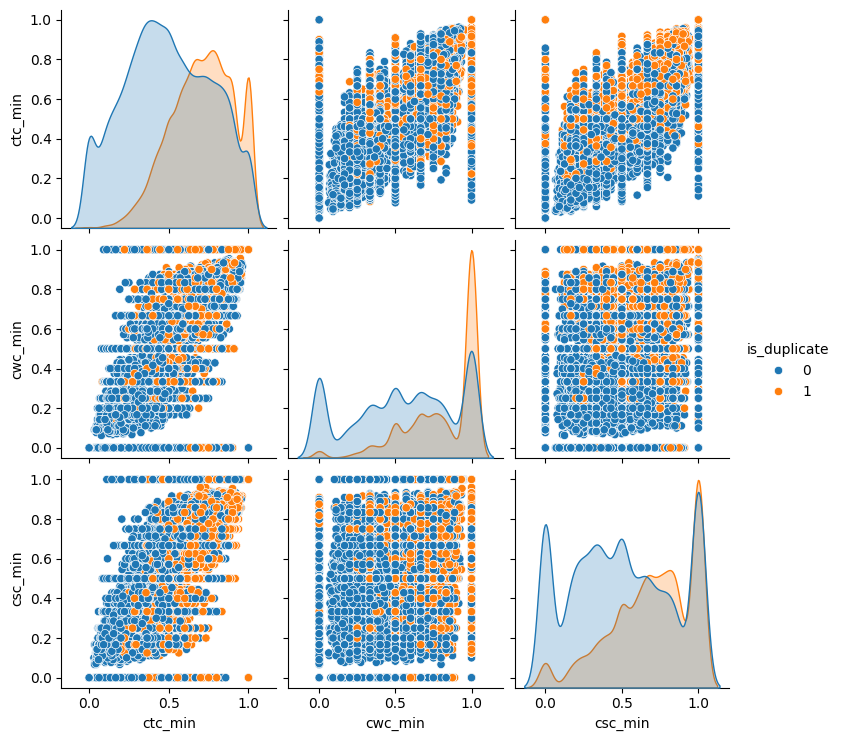

In [54]:
sns.pairplot(new_df[['ctc_min', 'cwc_min', 'csc_min', 'is_duplicate']],hue='is_duplicate')

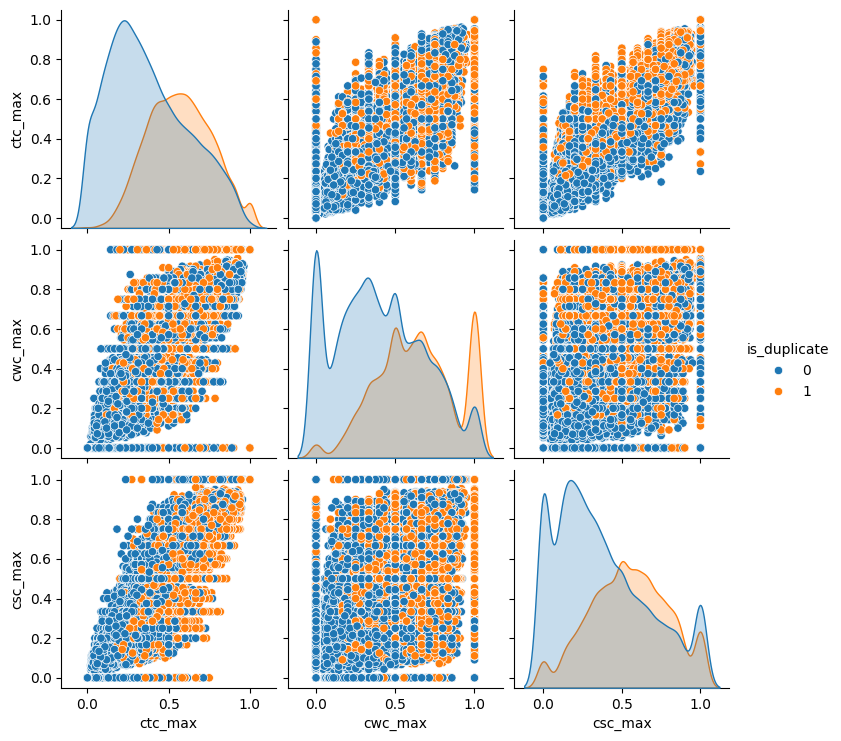

In [55]:
sns.pairplot(new_df[['ctc_max', 'cwc_max', 'csc_max', 'is_duplicate']],hue='is_duplicate')

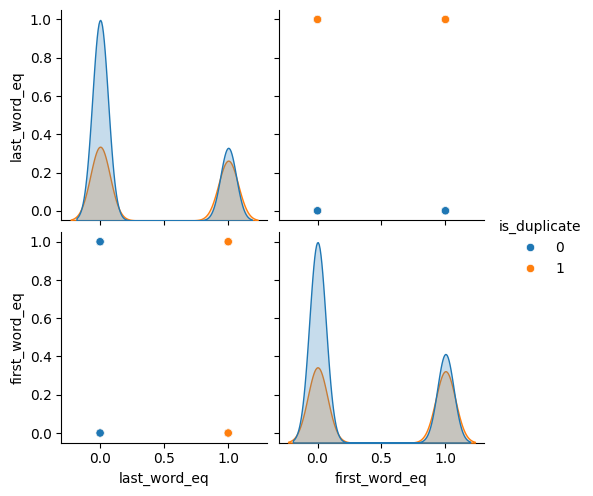

In [56]:
sns.pairplot(new_df[['last_word_eq', 'first_word_eq', 'is_duplicate']],hue='is_duplicate')

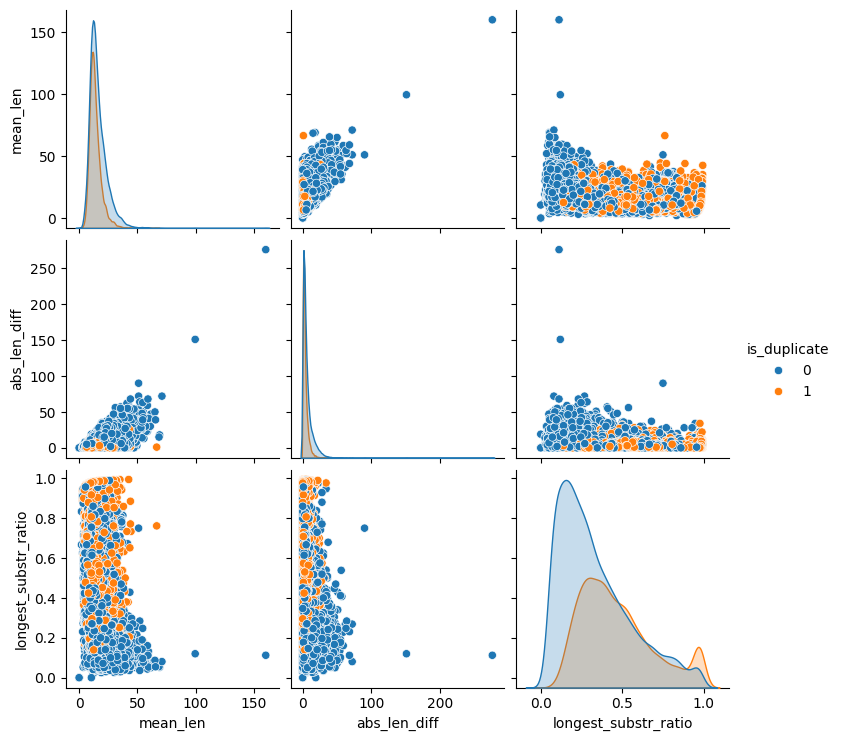

In [57]:
sns.pairplot(new_df[['mean_len', 'abs_len_diff','longest_substr_ratio', 'is_duplicate']],hue='is_duplicate')

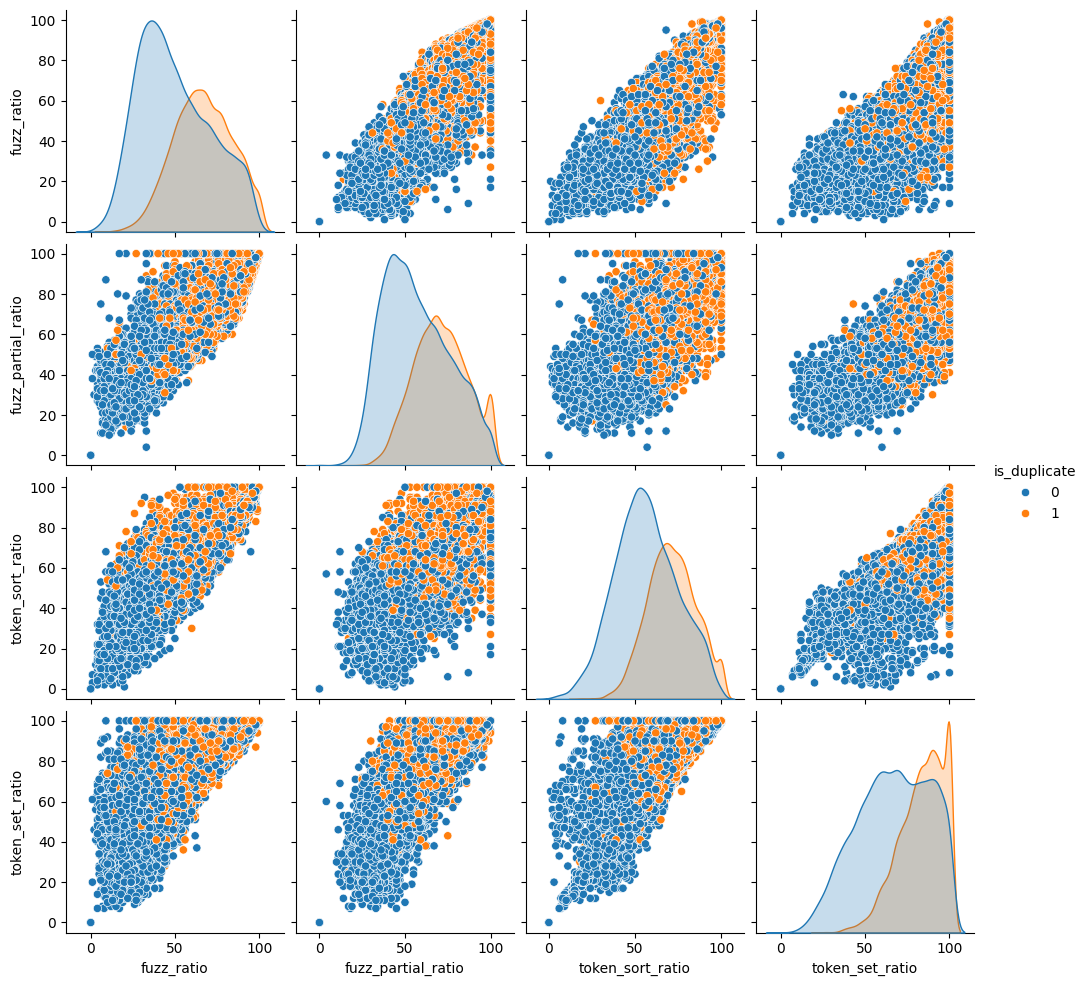

In [58]:
sns.pairplot(new_df[['fuzz_ratio', 'fuzz_partial_ratio','token_sort_ratio','token_set_ratio', 'is_duplicate']],hue='is_duplicate')

In [59]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

X = MinMaxScaler().fit_transform(new_df[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = new_df['is_duplicate'].values

In [60]:
from sklearn.manifold import TSNE

tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 31000 samples in 0.078s...
[t-SNE] Computed neighbors for 31000 samples in 7.781s...
[t-SNE] Computed conditional probabilities for sample 1000 / 31000
[t-SNE] Computed conditional probabilities for sample 2000 / 31000
[t-SNE] Computed conditional probabilities for sample 3000 / 31000
[t-SNE] Computed conditional probabilities for sample 4000 / 31000
[t-SNE] Computed conditional probabilities for sample 5000 / 31000
[t-SNE] Computed conditional probabilities for sample 6000 / 31000
[t-SNE] Computed conditional probabilities for sample 7000 / 31000
[t-SNE] Computed conditional probabilities for sample 8000 / 31000
[t-SNE] Computed conditional probabilities for sample 9000 / 31000
[t-SNE] Computed conditional probabilities for sample 10000 / 31000
[t-SNE] Computed conditional probabilities for sample 11000 / 31000
[t-SNE] Computed conditional probabilities for sample 12000 / 31000
[t-SNE] Computed conditional probabilities for sam

In [61]:
x_df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})


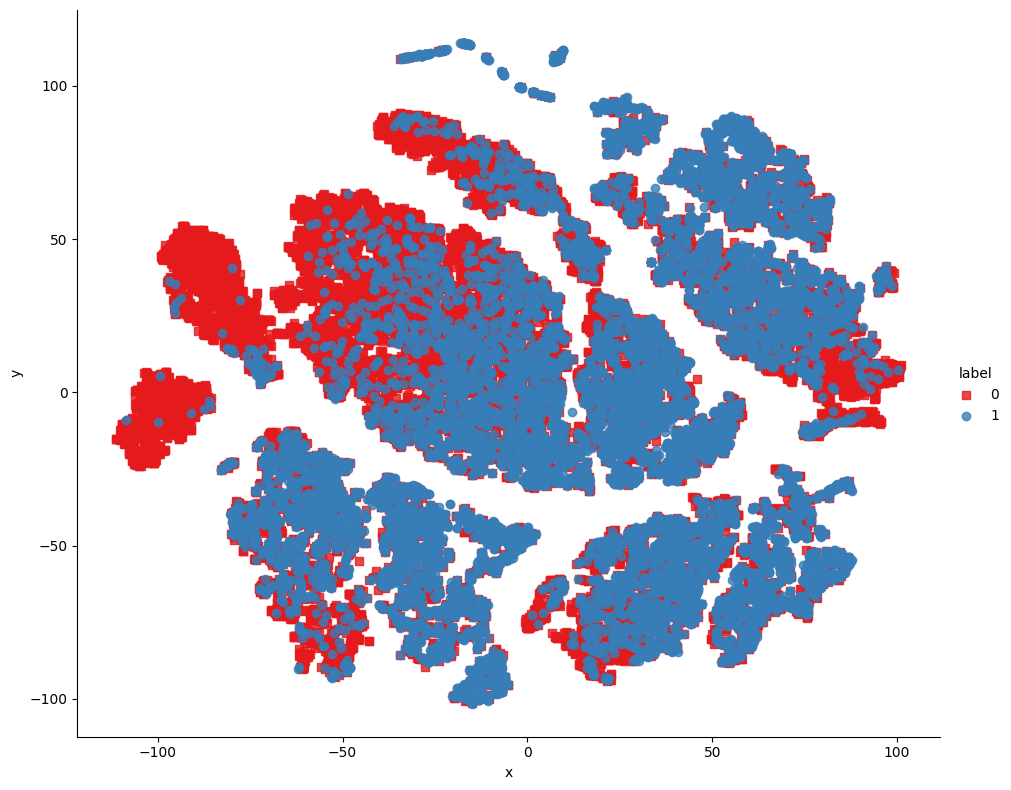

In [62]:
sns.lmplot(
    data=x_df,
    x='x',
    y='y',
    hue='label',
    fit_reg=False,
    height=8,  
    aspect=1.2, 
    palette="Set1",
    markers=['s', 'o']
)

plt.show()

In [63]:
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 31000 samples in 0.112s...
[t-SNE] Computed neighbors for 31000 samples in 11.188s...
[t-SNE] Computed conditional probabilities for sample 1000 / 31000
[t-SNE] Computed conditional probabilities for sample 2000 / 31000
[t-SNE] Computed conditional probabilities for sample 3000 / 31000
[t-SNE] Computed conditional probabilities for sample 4000 / 31000
[t-SNE] Computed conditional probabilities for sample 5000 / 31000
[t-SNE] Computed conditional probabilities for sample 6000 / 31000
[t-SNE] Computed conditional probabilities for sample 7000 / 31000
[t-SNE] Computed conditional probabilities for sample 8000 / 31000
[t-SNE] Computed conditional probabilities for sample 9000 / 31000
[t-SNE] Computed conditional probabilities for sample 10000 / 31000
[t-SNE] Computed conditional probabilities for sample 11000 / 31000
[t-SNE] Computed conditional probabilities for sample 12000 / 31000
[t-SNE] Computed conditional probabilities for sa

In [64]:
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.offline as py
py.init_notebook_mode(connected=True)

trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

In [65]:
ques_df = new_df[['question1','question2']]
ques_df.head()

question1  \
0            tháng 8 còn trường nào xét học bạ không   
1  chính sách hỗ trợ học phí cho sinh viên sư phạ...   
2  trường đại học sư phạm có cho thiếu học bạ tro...   
3  chương trình học ngành sp nga có phải 100 perc...   
4  không thuộc đối tượng ưu tiên có thể đăng kí ở...   

                                           question2  
0  những trường đại học còn nhận học bạ trong thá...  
1  những điều cần biết về chính sách hỗ trợ học p...  
2  có thể bổ sung học bạ sau khi nộp hồ sơ vào đạ...  
3  xuyên suốt bài giảng ngành sp nga có phải 100 ...  
4           điều kiện đăng ký ở ký túc xá của trường

In [66]:
final_df = new_df.drop(columns=['id','qid1','qid2','question1','question2'])
print(final_df.shape)
final_df.head()

(31000, 23)


is_duplicate  q1_len  q2_len  q1_num_words  q2_num_words  word_common  \
0             1      39      50             9            11            6   
1             1      59      70            14            16           11   
2             1      69      65            16            17            9   
3             1      65      68            13            14            8   
4             1      67      40            16            10            5   

   word_total  word_share   cwc_min   cwc_max  ...   ctc_max  last_word_eq  \
0          19        0.32  0.799984  0.799984  ...  0.545450           0.0   
1          30        0.37  0.999989  0.999989  ...  0.687496           0.0   
2          30        0.30  0.777769  0.636358  ...  0.529409           1.0   
3          25        0.32  0.666659  0.666659  ...  0.571424           0.0   
4          24        0.21  0.666656  0.399996  ...  0.312498           0.0   

   first_word_eq  abs_len_diff  mean_len  longest_substr_ratio  fuzz_ratio  \
0            0.0           2.0      10.0              0.200000          59   
1            0.0           2.0      15.0              0.783333          72   
2            0.0           1.0      16.5              0.257576          37   
3            0.0           1.0      13.5              0.515152          69   
4            0.0           6.0      13.0              0.317073          55   

   fuzz_partial_ratio  token_sort_ratio  token_set_ratio  
0                  56                66               81  
1                  89                78               89  
2                  37                68               74  
3                  76                78               77  
4                  65                53               65  

[5 rows x 23 columns]

In [67]:
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(ques_df['question1']) + list(ques_df['question2'])

cv = CountVectorizer(max_features=3000)
q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)

In [68]:
temp_df1 = pd.DataFrame(q1_arr, index= ques_df.index)
temp_df2 = pd.DataFrame(q2_arr, index= ques_df.index)
temp_df = pd.concat([temp_df1, temp_df2], axis=1)
temp_df.shape

(31000, 6000)

In [69]:
final_df = pd.concat([final_df, temp_df], axis=1)
print(final_df.shape)
final_df.head()

(31000, 6023)


is_duplicate  q1_len  q2_len  q1_num_words  q2_num_words  word_common  \
0             1      39      50             9            11            6   
1             1      59      70            14            16           11   
2             1      69      65            16            17            9   
3             1      65      68            13            14            8   
4             1      67      40            16            10            5   

   word_total  word_share   cwc_min   cwc_max  ...  2990  2991  2992  2993  \
0          19        0.32  0.799984  0.799984  ...     0     0     0     0   
1          30        0.37  0.999989  0.999989  ...     0     0     0     0   
2          30        0.30  0.777769  0.636358  ...     0     0     0     0   
3          25        0.32  0.666659  0.666659  ...     0     0     0     0   
4          24        0.21  0.666656  0.399996  ...     0     0     0     0   

   2994  2995  2996  2997  2998  2999  
0     0     0     0     0     0     0  
1     0     0     0     0     0     0  
2     0     0     0     0     0     0  
3     0     0     0     0     0     0  
4     0     0     0     0     0     0  

[5 rows x 6023 columns]

In [70]:
final_df.sample(10)

is_duplicate  q1_len  q2_len  q1_num_words  q2_num_words  word_common  \
27024             0     163     123            43            34           11   
15436             0      20      25             5             6            2   
25774             0      16      20             4             5            1   
25363             1      30      35             8             9            6   
28661             1      48      56            11            13           11   
15758             1      42     150            10            34            4   
16881             0      61     102            15            23            2   
26027             0     125      42            31             8            2   
22685             1      38      65             9            16            8   
18737             0      92      38            22             9            5   

       word_total  word_share   cwc_min   cwc_max  ...  2990  2991  2992  \
27024          64        0.17  0.461535  0.428568  ...     0     0     0   
15436          11        0.18  0.999900  0.499975  ...     0     0     0   
25774           9        0.11  0.499975  0.499975  ...     0     0     0   
25363          17        0.35  0.999967  0.749981  ...     0     0     0   
28661          24        0.46  0.999950  0.999950  ...     0     0     0   
15758          40        0.10  0.428565  0.214284  ...     0     0     0   
16881          38        0.05  0.099999  0.071428  ...     0     0     0   
26027          38        0.05  0.199996  0.055555  ...     0     0     0   
22685          25        0.32  0.999975  0.666656  ...     0     0     0   
18737          29        0.17  0.333322  0.142855  ...     0     0     0   

       2993  2994  2995  2996  2997  2998  2999  
27024     0     0     0     0     0     0     0  
15436     0     0     0     0     0     0     0  
25774     0     0     0     0     0     0     0  
25363     0     0     0     0     0     0     0  
28661     0     0     0     0     0     0     0  
15758     0     0     0     0     0     0     0  
16881     0     0     0     0     0     0     0  
26027     0     0     0     0     0     0     0  
22685     0     0     0     0     0     0     0  
18737     0     0     0     0     0     0     0  

[10 rows x 6023 columns]

In [71]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(final_df.iloc[:,1:].values,final_df.iloc[:,0].values,test_size=0.2,random_state=1)

In [72]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.7777419354838709

In [73]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred1 = xgb.predict(X_test)
accuracy_score(y_test,y_pred1)

0.7783870967741936

In [74]:
from sklearn.metrics import confusion_matrix

In [75]:
# for random forest model
confusion_matrix(y_test,y_pred)

array([[3303,  585],
       [ 793, 1519]])

In [76]:
# for xgboost model
confusion_matrix(y_test,y_pred1)

array([[3253,  635],
       [ 739, 1573]])

In [77]:
def test_common_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))    
    return len(w1 & w2)

In [78]:
def test_total_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))    
    return (len(w1) + len(w2))

In [79]:
def test_fetch_token_features(q1,q2):
    
    SAFE_DIV = 0.0001 

    # STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features


In [80]:
def test_fetch_length_features(q1,q2):
    
    length_features = [0.0]*3
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2
    
    strs = list(distance.lcsubstrings(q1, q2))
    length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)
    
    return length_features

In [81]:
def test_fetch_fuzzy_features(q1,q2):
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [82]:
def query_point_creator(q1,q2):
    
    input_query = []
    
    # preprocess
    q1 = preprocess(q1)
    q2 = preprocess(q2)
    
    # fetch basic features
    input_query.append(len(q1))
    input_query.append(len(q2))
    
    input_query.append(len(q1.split(" ")))
    input_query.append(len(q2.split(" ")))
    
    input_query.append(test_common_words(q1,q2))
    input_query.append(test_total_words(q1,q2))
    input_query.append(round(test_common_words(q1,q2)/test_total_words(q1,q2),2))
    
    # fetch token features
    token_features = test_fetch_token_features(q1,q2)
    input_query.extend(token_features)
    
    # fetch length based features
    length_features = test_fetch_length_features(q1,q2)
    input_query.extend(length_features)
    
    # fetch fuzzy features
    fuzzy_features = test_fetch_fuzzy_features(q1,q2)
    input_query.extend(fuzzy_features)
    
    #phobert
    # semantic_features = test_phobert_features(q1, q2)
    # input_query.append(semantic_features)

    # bow feature for q1
    q1_bow = cv.transform([q1]).toarray()
    
    # bow feature for q2
    q2_bow = cv.transform([q2]).toarray()
    
    return np.hstack((np.array(input_query).reshape(1,22),q1_bow,q2_bow))

In [83]:
q5 = 'Học kì hè có bao nhiêu môn?'
q6 = 'Khi nào đăng kí học kì hè?'

In [84]:
query = query_point_creator(q5, q6)
print(query.shape)  # Xác nhận số lượng đặc trưng


(1, 6022)


In [85]:
print(X_train.shape)

(24800, 6022)


In [86]:
print(rf.n_features_in_) 


6022


In [87]:
rf.predict(query_point_creator(q5,q6))

array([0])

In [88]:
cv

CountVectorizer(max_features=3000)

In [89]:
import pickle

pickle.dump(rf,open('model.pkl','wb'))
pickle.dump(cv,open('cv.pkl','wb'))